In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import cv2

from skimage import data, io, filters, color, exposure

In [2]:
from tensorflow.keras.applications.vgg19 import preprocess_input, VGG19, decode_predictions 

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Function to load and operate on the content and style images
def get_data(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = img[tf.newaxis, :]
    return img

In [5]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [6]:
path = "/content/gdrive/MyDrive/MSiA432/DL Project/02. Modeling/"

## Starry + 000001.jpg

In [7]:
content_image = load_img(path + '/Content/000001.jpg')
style_image = load_img(path + '/Style/The-Starry-Night-Van Gogh.jpeg')

Text(0.5, 1.0, 'Style Image')

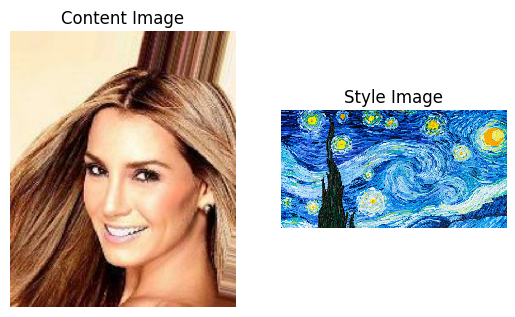

In [8]:
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(content_image[0,:,:,:], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title('Content Image')


plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(style_image[0,:,:,:], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title('Style Image')

In [9]:
vgg = VGG19(include_top=False, weights='imagenet')

for layer in vgg.layers:
  print(layer.name)

80134624/80134624 [==============================] - 0s 0us/step
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [10]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [11]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [12]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 268, 512, 64)
  min:  0.0
  max:  850.6655
  mean:  39.87902

block2_conv1
  shape:  (1, 134, 256, 128)
  min:  0.0
  max:  5572.755
  mean:  238.72781

block3_conv1
  shape:  (1, 67, 128, 256)
  min:  0.0
  max:  11351.477
  mean:  241.25798

block4_conv1
  shape:  (1, 33, 64, 512)
  min:  0.0
  max:  21122.652
  mean:  900.36536

block5_conv1
  shape:  (1, 16, 32, 512)
  min:  0.0
  max:  4205.3438
  mean:  72.89217



In [13]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [14]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])
    

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [15]:
### Example Execution

extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0
    max:  49945.9
    mean:  454.30328

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  66826.36
    mean:  14105.286

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  344336.06
    mean:  12280.863

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  2735046.5
    mean:  196155.25

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  111507.195
    mean:  1397.3347

Contents:
   block5_conv2
    shape:  (1, 31, 26, 512)
    min:  0.0
    max:  1046.686
    mean:  13.434338


In [16]:
## Getting the targets

extractor = StyleContentModel(style_layers, content_layers)

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [18]:
## Generated image
image = tf.Variable(content_image)

In [17]:
# Since this is a float image, define a function to keep the pixel values between 0 and 1:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [19]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight=1e-2
content_weight=1e4

In [20]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [21]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [22]:
## Training
epochs = 2000

for i in range(epochs):
  if(i % 100 == 0):
    print(f'Epoch {i}')
  train_step(image)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900


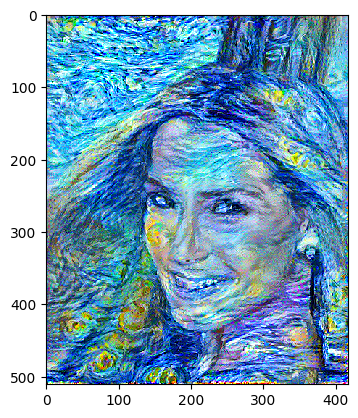

In [23]:
plt.imshow(image[0,:,:,:], cmap=plt.cm.gray_r, interpolation='nearest')

## Starry+000013.jpg

In [24]:
content_image = load_img(path + '/Content/000013.jpg')
style_image = load_img(path + '/Style/The-Starry-Night-Van Gogh.jpeg')

Text(0.5, 1.0, 'Style Image')

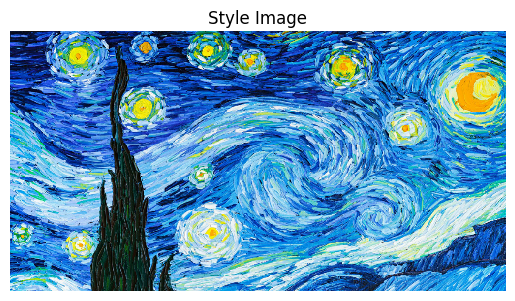

In [25]:
plt.axis('off')
plt.imshow(style_image[0,:,:,:], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title('Style Image')

In [26]:
## Getting the targets

extractor = StyleContentModel(style_layers, content_layers)

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [27]:
## Generated image
image = tf.Variable(content_image)

In [28]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight=1e-2
content_weight=1e4

In [29]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [30]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [31]:
## Training
epochs = 2000

for i in range(epochs):
  if(i % 100 == 0):
    print(f'Epoch {i}')
  train_step(image)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900


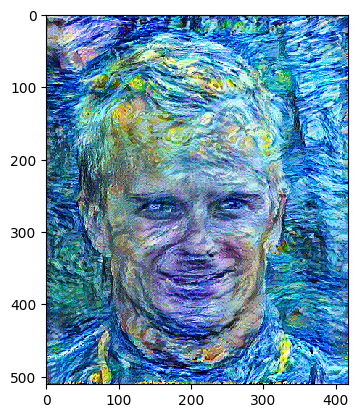

In [32]:
plt.imshow(image[0,:,:,:], cmap=plt.cm.gray_r, interpolation='nearest')

## Scream+000001.jpg

In [34]:
content_image = load_img(path + '/Content/000001.jpg')
style_image = load_img(path + '/Style/the_scream.png')

Text(0.5, 1.0, 'Style Image')

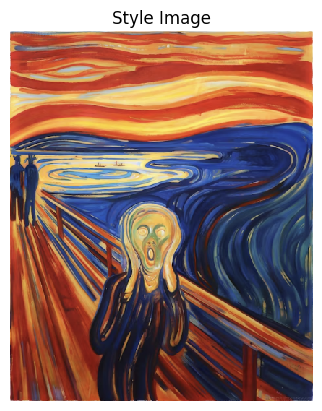

In [35]:
plt.axis('off')
plt.imshow(style_image[0,:,:,:], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title('Style Image')

In [36]:
## Getting the targets

extractor = StyleContentModel(style_layers, content_layers)

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [37]:
## Generated image
image = tf.Variable(content_image)

In [38]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight=1e-2
content_weight=1e4

In [39]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [40]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [41]:
## Training
epochs = 2000

for i in range(epochs):
  if(i % 100 == 0):
    print(f'Epoch {i}')
  train_step(image)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900


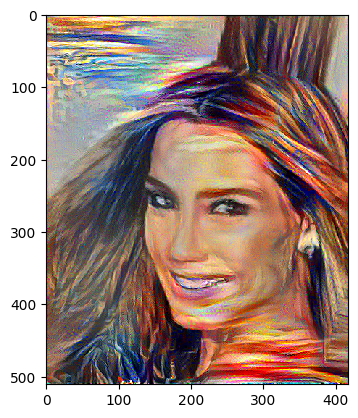

In [42]:
plt.imshow(image[0,:,:,:], cmap=plt.cm.gray_r, interpolation='nearest')

## Scream+000013.jpg

In [43]:
content_image = load_img(path + '/Content/000013.jpg')
style_image = load_img(path + '/Style/the_scream.png')

Text(0.5, 1.0, 'Style Image')

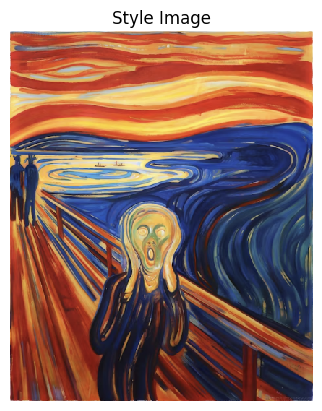

In [44]:
plt.axis('off')
plt.imshow(style_image[0,:,:,:], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title('Style Image')

In [45]:
## Getting the targets

extractor = StyleContentModel(style_layers, content_layers)

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [46]:
## Generated image
image = tf.Variable(content_image)

In [47]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight=1e-2
content_weight=1e4

In [48]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [49]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [50]:
## Training
epochs = 2000

for i in range(epochs):
  if(i % 100 == 0):
    print(f'Epoch {i}')
  train_step(image)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900


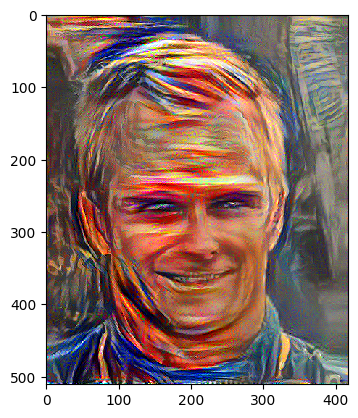

In [51]:
plt.imshow(image[0,:,:,:], cmap=plt.cm.gray_r, interpolation='nearest')